# 00 – Setup & Data Exploration

**Goal:** Verify environment, explore P01 data structure, display sample images, and confirm all tools are installed.

**Data source:** `P01/` directory containing:
- `BraTS/` – NIfTI in BraTS format (t1, t1c, t2, fla) for 5 timepoints
- `DICOM/` – Raw DICOM series (T1C, T1w, T2w, FLR, RTP)
- `tumor segmentation/` – Ground-truth tumor masks (.nii.gz) for all timepoints

In [1]:
import sys
import os
from pathlib import Path

# ── Paths ──────────────────────────────────────────────────────────────────
# Adjust DATA_ROOT to point to the P01 folder relative to this notebook
NOTEBOOK_DIR = Path(os.getcwd())
REPO_ROOT    = NOTEBOOK_DIR.parent.parent.parent / 'data'  # ml/exploration/ → repo root
DATA_ROOT    = REPO_ROOT / 'P01'
BRATS_DIR    = DATA_ROOT / 'BraTS'
DICOM_DIR    = DATA_ROOT / 'DICOM'
MASK_DIR     = DATA_ROOT / 'tumor segmentation'

print(f'Repo root : {REPO_ROOT}')
print(f'Data root : {DATA_ROOT}')
print(f'BraTS dir : {BRATS_DIR}')
print(f'DICOM dir : {DICOM_DIR}')
print(f'Mask dir  : {MASK_DIR}')
assert DATA_ROOT.exists(), f'DATA_ROOT not found: {DATA_ROOT}'
print('\n✅ Paths OK')

Repo root : /Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/data
Data root : /Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/data/P01
BraTS dir : /Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/data/P01/BraTS
DICOM dir : /Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/data/P01/DICOM
Mask dir  : /Users/nivkapliser/Desktop/school/final-project/new-onco/oncoflow/data/P01/tumor segmentation

✅ Paths OK


In [6]:
!pip install -r ../requirements.txt

  Using cached pydicom-3.0.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached simpleitk-2.5.3-cp311-abi3-macosx_11_0_arm64.whl.metadata (7.2 kB)
  Using cached transformers-5.2.0-py3-none-any.whl.metadata (32 kB)
  Using cached accelerate-1.12.0-py3-none-any.whl.metadata (19 kB)
  Using cached nnunetv2-2.6.4.tar.gz (212 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ipywidgets-8.1.8-py3-none-any.whl.metadata (2.4 kB)
  Using cached papermill-2.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached kaleido-1.2.0-py3-none-any.whl.metadata (5.6 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached huggingface_hub-1.4.1-py3-none-any.whl.metadata (13 kB)
  Using cached tokenizers-0.22.2-cp39-abi3-macosx_11_0_arm64.whl.metadata (7.3 kB)
  Using cached typer_slim-0.24.0-py3-none-any.whl.metadata (4.2 kB)
  Using cached safetensors-0.7.0-cp38-abi3-macosx_11_0_arm

In [7]:
# ── Add utils to path ──────────────────────────────────────────────────────
utils_path = str(NOTEBOOK_DIR.parent / 'utils')
if utils_path not in sys.path:
    sys.path.insert(0, utils_path)

# Try imports
import importlib, subprocess

def check_import(pkg, import_name=None):
    name = import_name or pkg
    try:
        importlib.import_module(name)
        print(f'  ✅  {pkg}')
        return True
    except ImportError:
        print(f'  ❌  {pkg}   → pip install {pkg}')
        return False

print('=== Checking required packages ===')
pkgs = [
    ('nibabel', None),
    ('SimpleITK', 'SimpleITK'),
    ('pydicom', None),
    ('numpy', None),
    ('scipy', None),
    ('matplotlib', None),
    ('pandas', None),
    ('seaborn', None),
    ('torch', None),
    ('transformers', None),
]
all_ok = all(check_import(p, n) for p, n in pkgs)

# Check dcm2niix
import shutil
if shutil.which('dcm2niix'):
    print('  ✅  dcm2niix (CLI)')
else:
    print('  ⚠️   dcm2niix not found → brew install dcm2niix (optional, used in notebook 01)')

=== Checking required packages ===
  ✅  nibabel
  ✅  SimpleITK
  ✅  pydicom
  ✅  numpy
  ✅  scipy
  ✅  matplotlib
  ✅  pandas
  ✅  seaborn
  ✅  torch
  ✅  transformers
  ⚠️   dcm2niix not found → brew install dcm2niix (optional, used in notebook 01)


In [8]:
# ── GPU check ──────────────────────────────────────────────────────────────
import torch
cuda_available = torch.cuda.is_available()
mps_available  = torch.backends.mps.is_available()  # Apple Silicon

if cuda_available:
    device = 'cuda'
    print(f'🎮 GPU: {torch.cuda.get_device_name(0)}')
    print(f'   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB')
elif mps_available:
    device = 'mps'
    print('🍎 Apple Silicon MPS available')
else:
    device = 'cpu'
    print('💻 No GPU detected – running on CPU (inference notebooks will run in stub mode)')

print(f'\nActive device: {device}')

🍎 Apple Silicon MPS available

Active device: mps


In [9]:
# ── Explore P01 data structure ──────────────────────────────────────────────
from dicom_utils import get_p01_brats_paths, get_p01_mask_paths, get_p01_dicom_series, get_nifti_info

brats_paths = get_p01_brats_paths(BRATS_DIR)
mask_paths  = get_p01_mask_paths(MASK_DIR)
dicom_series = get_p01_dicom_series(DICOM_DIR)

print('=== BraTS NIfTI files ===')
for tp, mods in brats_paths.items():
    print(f'  {tp}: {list(mods.keys())}')

print('\n=== Ground-truth tumor masks ===')
for tp, path in mask_paths.items():
    info = get_nifti_info(path)
    print(f'  {tp}: shape={info["shape"]}, spacing={info["spacing_mm"]}, {info["file_size_mb"]} MB')

print('\n=== DICOM series ===')
for name in dicom_series:
    n_dcm = len(list(Path(dicom_series[name]).glob('*.dcm')))
    print(f'  {name}: {n_dcm} files')

=== BraTS NIfTI files ===
  baseline: ['t1', 't1c', 't2', 'fla']
  fu1: ['t1', 't1c', 't2', 'fla']
  fu2: ['t1', 't1c', 't2', 'fla']
  fu3: ['t1', 't1c', 't2', 'fla']
  fu4: ['t1', 't1c', 't2', 'fla']

=== Ground-truth tumor masks ===
  baseline: shape=(240, 240, 155), spacing=(1.0, 1.0, 1.0), 0.02 MB
  fu1: shape=(240, 240, 155), spacing=(1.0, 1.0, 1.0), 0.02 MB
  fu2: shape=(240, 240, 155), spacing=(1.0, 1.0, 1.0), 0.02 MB
  fu3: shape=(240, 240, 155), spacing=(1.0, 1.0, 1.0), 0.02 MB
  fu4: shape=(240, 240, 155), spacing=(1.0, 1.0, 1.0), 0.02 MB

=== DICOM series ===
  FLR_2020-01-07: 33 files
  FLR_2020-02-14: 33 files
  FLR_2020-05-20: 34 files
  FLR_2020-08-10: 35 files
  FLR_2020-11-10: 33 files
  RTP_2020-01-10: 356 files
  T1C_2020-01-07: 36 files
  T1C_2020-02-14: 33 files
  T1C_2020-05-20: 34 files
  T1C_2020-08-10: 33 files
  T1C_2020-11-10: 33 files
  T1W_2020-05-20: 34 files
  T1w_2020-01-07: 36 files
  T1w_2020-02-14: 33 files
  T1w_2020-08-10: 33 files
  T1w_2020-11-10:

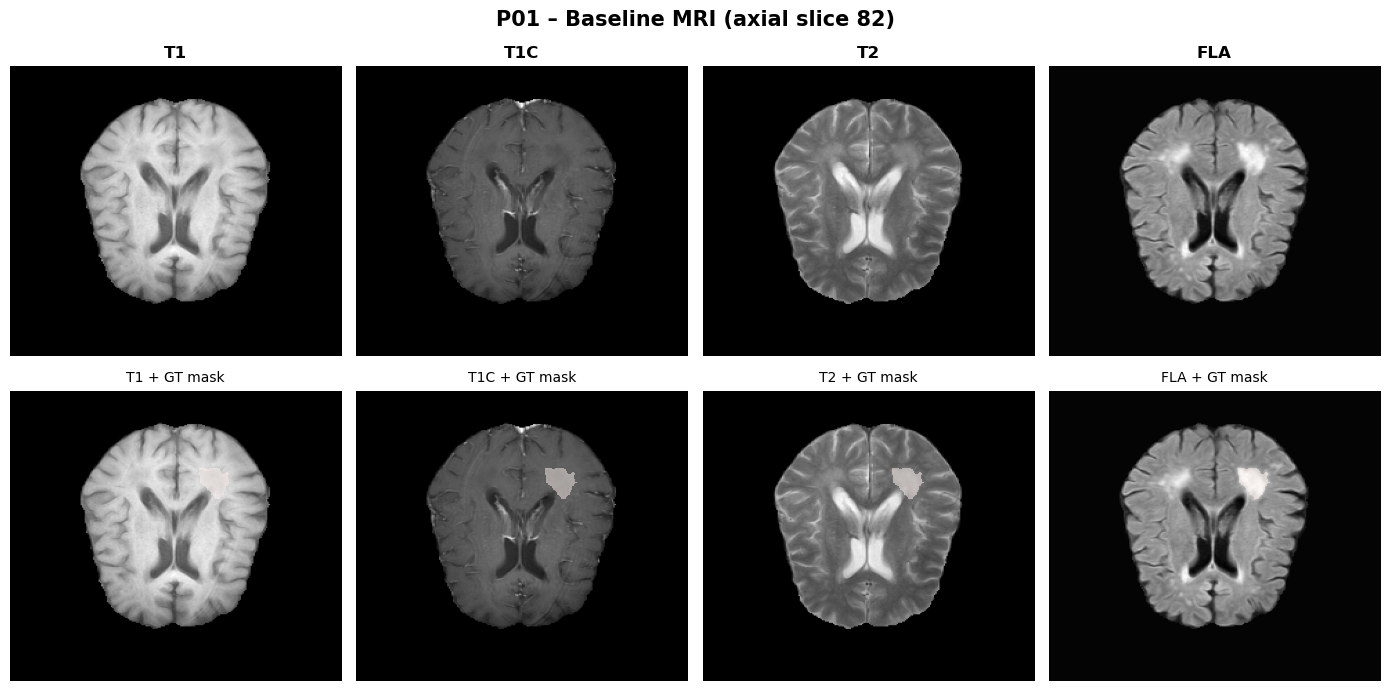

Saved: outputs/00_baseline_overview.png


In [10]:
# ── Display sample BraTS slices for all modalities (baseline) ───────────────
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

tp = 'baseline'
modalities = list(brats_paths[tp].keys())
n = len(modalities)

fig, axes = plt.subplots(2, n, figsize=(n * 3.5, 7))
gt = nib.load(mask_paths[tp]).get_fdata()

for col, mod in enumerate(modalities):
    img = nib.load(brats_paths[tp][mod])
    vol = img.get_fdata()
    # Find best slice
    best_sl = int(gt.sum(axis=(0,1)).argmax())

    # Top row: raw MRI
    axes[0, col].imshow(vol[:, :, best_sl].T, cmap='gray', origin='lower', aspect='auto')
    axes[0, col].set_title(f'{mod.upper()}', fontsize=12, fontweight='bold')
    axes[0, col].axis('off')

    # Bottom row: MRI + mask overlay
    axes[1, col].imshow(vol[:, :, best_sl].T, cmap='gray', origin='lower', aspect='auto')
    gm = gt[:, :, best_sl].T
    if gm.any():
        axes[1, col].imshow(np.ma.masked_where(gm == 0, gm), cmap='Reds',
                            alpha=0.5, origin='lower', aspect='auto')
    axes[1, col].set_title(f'{mod.upper()} + GT mask', fontsize=10)
    axes[1, col].axis('off')

fig.suptitle(f'P01 – Baseline MRI (axial slice {best_sl})', fontsize=15, fontweight='bold')
plt.tight_layout()
plt.savefig('../outputs/00_baseline_overview.png', dpi=120, bbox_inches='tight')
plt.show()
print('Saved: outputs/00_baseline_overview.png')

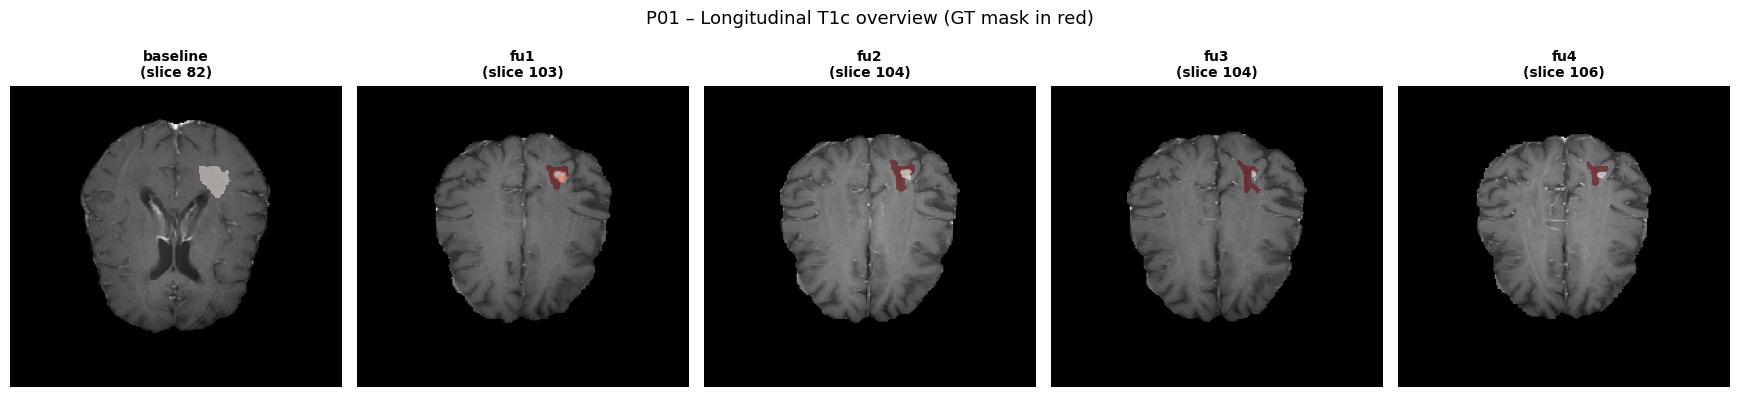

In [11]:
# ── Show all timepoints (T1c only) ─────────────────────────────────────────
timepoints = list(brats_paths.keys())
fig, axes = plt.subplots(1, len(timepoints), figsize=(len(timepoints) * 3.5, 4))

for ax, tp in zip(axes, timepoints):
    if 't1c' not in brats_paths[tp]:
        ax.text(0.5, 0.5, 'N/A', ha='center')
        continue
    vol = nib.load(brats_paths[tp]['t1c']).get_fdata()
    gt  = nib.load(mask_paths[tp]).get_fdata()
    sl  = int(gt.sum(axis=(0,1)).argmax())
    ax.imshow(vol[:, :, sl].T, cmap='gray', origin='lower', aspect='auto')
    gm = gt[:, :, sl].T
    if gm.any():
        ax.imshow(np.ma.masked_where(gm==0, gm), cmap='Reds', alpha=0.5, origin='lower', aspect='auto')
    vol_cc = gm.sum() * float(np.prod(nib.load(mask_paths[tp]).header.get_zooms()[:2])) / 1000
    ax.set_title(f'{tp}\n(slice {sl})', fontsize=10, fontweight='bold')
    ax.axis('off')

fig.suptitle('P01 – Longitudinal T1c overview (GT mask in red)', fontsize=13)
plt.tight_layout()
plt.savefig('../outputs/00_longitudinal_overview.png', dpi=120, bbox_inches='tight')
plt.show()

Ground-truth tumor volumes:
  baseline: 14.81 cm³
  fu1: 3.10 cm³
  fu2: 3.91 cm³
  fu3: 2.29 cm³
  fu4: 1.26 cm³


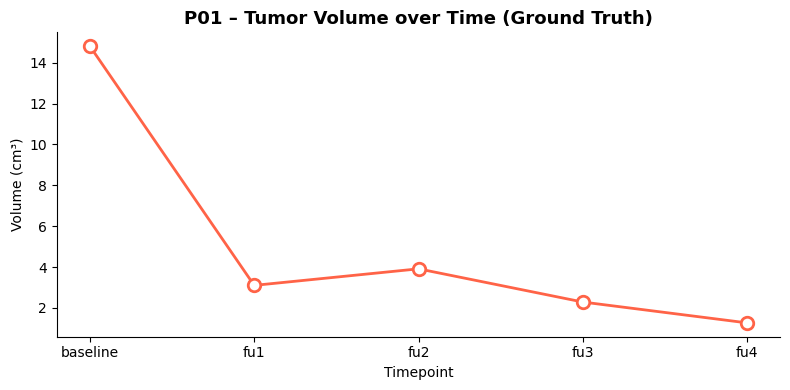

In [12]:
# ── Longitudinal volume from ground-truth masks ─────────────────────────────
from metrics import compute_volume_from_nifti

volumes_gt = {}
print('Ground-truth tumor volumes:')
for tp, path in mask_paths.items():
    vol_cc = compute_volume_from_nifti(path)
    volumes_gt[tp] = vol_cc
    print(f'  {tp}: {vol_cc:.2f} cm³')

# Quick plot
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(volumes_gt.keys()), list(volumes_gt.values()), '-o', color='tomato',
        linewidth=2, markersize=9, markerfacecolor='white', markeredgewidth=2)
ax.set_xlabel('Timepoint'); ax.set_ylabel('Volume (cm³)')
ax.set_title('P01 – Tumor Volume over Time (Ground Truth)', fontsize=13, fontweight='bold')
ax.spines[['top','right']].set_visible(False)
plt.tight_layout()
plt.savefig('../outputs/00_gt_volumes.png', dpi=120, bbox_inches='tight')
plt.show()